<a href="https://colab.research.google.com/github/akshnataraj/Pixel-by-pixel-classification/blob/main/MoG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import sys
flt_min = sys.float_info.min # to add a small float variable to avoid divide by zero errors.

### A.1) Helper functions to plot the numpy arrays as images

In [ ]:
def plot(im, gt, title1, title2, i):
    """
    a function that plots the original image and the ground truth image side by side, with it's corresponding titles
    
    Input parameters:
    im -- original RGB image
    gt -- ground truth binary mask
    
    Returns:
    None
    
    """
    fig = plt.figure(figsize=plt.figaspect(0.3))
    plt.subplot(1, 2, 1)
    plt.imshow(im)
    plt.gca().set_title(title1 + " - " + str(i+1))
    plt.subplot(1, 2, 2)
    plt.imshow(gt)
    plt.gca().set_title(title2 + " - " + str(i+1))
    
def plot_three(im, gt, posterior, i):
    """
    a function that plots the original image, the ground truth image and the posterior side by side, with it's corresponding titles
    
    Input parameters:
    im -- original RGB test image
    gt -- ground truth binary mask
    posterior -- posterior predictions based on im
    
    Returns:
    None
    
    """
    fig = plt.figure(figsize=plt.figaspect(0.3))
    plt.subplot(1, 3, 1)
    plt.imshow(im)
    plt.gca().set_title('Original Image' + " - " + str(i+1))
    plt.subplot(1, 3, 2)
    plt.imshow(posterior)
    plt.gca().set_title('Posterior' + " - " + str(i+1))
    plt.subplot(1, 3, 3)
    plt.imshow(gt)
    plt.gca().set_title('Ground Truth Binary mask' + " - " + str(i+1))
    

def threshold(gt):
    """ 
    a function that takes thresholds the ground truth image into 0s and 1s based on pixel value, 
    assigns 1 if pixel value >= 0.5 (1 denoting apple class)
    assigns 0 if pixel value < 0.5 (0 denoting non-apple class)
    
    Input parameters:
    gt -- ground truth image 
    
    Returns:
    gt -- thresholded ground truth image
    """
    gt[gt >= 0.5] = 1 # if pixel value is greater than 0.5 => assign 1
    gt[gt < 0.5] = 0 # if pixel value is less than 0 => assign 0
    return gt

### A.2) Displaying the training set

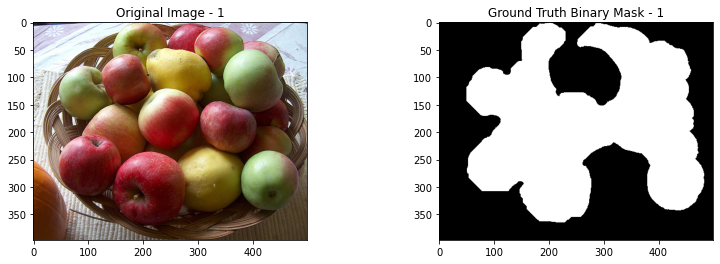

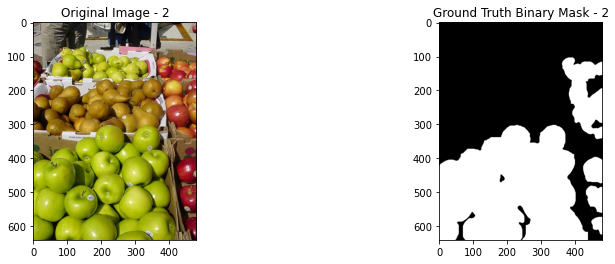

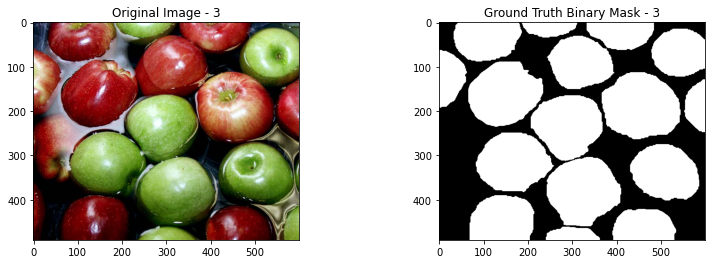

In [ ]:
img_files = glob.glob("apples/train/*.jpg")
gt_files = glob.glob("masks/train/*.png")
ColorImgs = []
GroundTruthImgs = []
for i in range(len(img_files)):
    im = plt.imread(img_files[i])
    gt = plt.imread(gt_files[i])
    ColorImgs.append(im) # contains all the RGB pixels of all train images
    gt = threshold(gt)
    GroundTruthImgs.append(gt) # contains all the ground truth pixels of all train images
    plot(im, gt, "Original Image", "Ground Truth Binary Mask", i)

Explanation - The above plots are the images of the training set.
Original image 1 :: 1st RGB train image ; dimension - (397, 500, 3)
Groundtruth image 1 :: Binary mask of Original image 1
Original image 2 :: 2nd RGB train image ; dimension - (640, 480, 3)
Groundtruth image 2 :: Binary mask of Original image 2
Original image 3 :: 3rd RGB train image ; dimension - (491, 600, 3)
Groundtruth image 3 :: Binary mask of Original image 3

## B) Train a mixture of Gaussians model for distinguishing apple vs. non-apple pixels. Use red, green, and blue as your dimensions for now. Make any other decisions you need to, and document them in your jupyter notebook.

### B.1) Helper functions required to train the model:

In [ ]:
def split_train_set(images, truths):
    """
    This function takes in the original images and groundtruth images of the training set, splits the data into 
    apple vs non apple so that we can train two models: appleSkin, nonappleSkin. 
    
    Input parameters:
    images -- original RGB image
    truths -- binary mask of the RGB image
    
    Returns:
    appleSkin -- contains array of pixels that represents "apple" which is our True class
    nonappleSkin -- contains array of pixels that represents "not an apple" which is our False class
    
    """
    
    appleSkin = []
    nonappleSkin = []
    

    for i in range(len(images)): #for every image in the training set
        image = images[i]
        image = image/255  #to normalize 0-255 into a 0-1 pixel represenation
        
        # consider any one channel (either R,G or B) in the binary mask and keep the 
        # channel as a reference to classify pixel as apple vs non-apple
        red_channel = (truths[i][:, :, 0]).astype(int)

        #iteratively traverse through each pixel in ground truth mask, 
        # if the ground truth pixel value = 1, add original pixel value to the apple skin list
        # if the ground truth pixel value = 0, add original pixel value to the nonapple skin list
        for row in range(red_channel.shape[0]):
            for col in range(red_channel.shape[1]):
                if red_channel[row, col] == 1:
                    appleSkin.append(image[row, col])
                else:
                    nonappleSkin.append(image[row, col])

    # for computational ease, we convert the list into np array and transpose to avoid dimensionality issues.
    appleSkin = np.asarray(appleSkin).T
    nonappleSkin = np.asarray(nonappleSkin).T
    
    return appleSkin, nonappleSkin

def gaussProb(data, mean, cov):
    """
    Returns the likelihood that each data point in x belongs to the Gaussian described by mean and 
    var.
    
    Keyword arguments:
    data -- d by n matrix of data points. n is the number of data points.
    mean -- d by 1 vector containing the mean parameter of the Gaussian distribution.
    cov -- d by d matrix containing the covariance parameter of the Gaussian distribution.
    
    Returns: 
    prob -- scalar containing the likelihood that each data point in data belongs to the Gaussian 
    distribution defined by mean and cov.
    """
    
    data = data - mean[:, None] # take the mean of the data
    inv_cov = np.linalg.inv(cov) # finding the covariance
    exp = np.exp(-0.5 * (data.T @ inv_cov * data.T).sum(1)) # computing the second half of the gaussian normal distribution equation
    factor = 1/np.sqrt(((2*np.pi)**3) * np.linalg.det(cov)) # computing the first half of the gaussian normal distribution equation
    prob = factor * exp # multiplying both terms for to get the actual probability value
    return prob

def getMixGaussLogLike(data, mixGaussEst):
    """
    Calculate the log likelihood for the whole dataset under a mixture of Gaussians model.
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.

    Returns: 
    logLike -- scalar containing the log likelihood.
    
    """
    # find total number of data items 
    nData = data.shape[1]
    
    # initialize log likelihoods
    logLike = np.zeros((mixGaussEst['k'], nData))
    
    # run through each data item 
    for cGauss in range(mixGaussEst['k']):
        # calculate likelihood of this data point under mixture of Gaussians model
        # for ease of computation, take variables out of dictionary and use them
        curWeight = mixGaussEst['weight'][cGauss]
        curMean = mixGaussEst['mean'][:, cGauss]
        curCov = mixGaussEst['cov'][:, :, cGauss]
        logLike[cGauss, :] = curWeight * gaussProb(data, curMean, curCov)
        
    # once the logLike is computed for every gaussian, we take the log of the sum of likelihoods
    # add to total log like
    log_likelihood = np.sum(np.log(np.sum(logLike, axis=0) + flt_min)) #adding flt_min to avoid divide by zero error

    return log_likelihood.item()



### B.2) Main Function that trains the model using EM Algorithm

In [ ]:
def fitMixGauss(data, k):
    """
    Estimate a k MoG model that would fit the data. Incremently plots the outcome.
               
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    k -- scalar representing the number of gaussians to use in the MoG model.
    
    Returns: 
    mixGaussEst -- dict containing the estimated MoG parameters.
    
    """   
    # extract the shape of data
    nDims, nData = data.shape

    # finding the mean of the data
    mean = np.mean(data, axis=1)

    # finding the covariance of the data
    cov = (1 / (nData-1)) * (data - mean[:, None]) @ (data - mean[:, None]).T

    # post hidden is a hidden variable in the E-M algorithm that stores
    # the responsibilties (likelihoods) for each each gaussian
    postHidden = np.zeros(shape=(k, nData))
    
    # we will initialize the values to random values
    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    # we multiply by (1/k) because we want the weights from each gaussian to add upto 1
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    # we multiply by 0.5 because our pixel representation is between 0 to 1
    mixGaussEst['mean'] = 0.5 * np.random.randn(nDims, k) 
    # we randomly intialize the covariance parameters
    mixGaussEst['cov'] =  np.zeros(shape=(nDims, nDims, k))
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)

    # calculate current likelihood
    log_likelihood = getMixGaussLogLike(data, mixGaussEst)

    # variable counting the number of iterations
    cIter = 1

    
    #     MAIN E-M ROUTINE  
    #     In the E-M algorithm, we calculate a complete posterior distribution over                                  
    #     the (nData) hidden variables in the E-Step.  
    #     In the M-Step, we update the parameters of the Gaussians (mean, cov, w).   
    
    while True: #run an infinite loop until likelihood update is very small

        # ===================== =====================
        # Expectation step
        # ===================== =====================
        
        # extract required variables from the dictionary
        #calculate posterior probability that this data point came from each of the Gaussians
        for cGauss in range(k):
            curWeight = mixGaussEst['weight'][cGauss]
            curMean = mixGaussEst['mean'][:, cGauss]
            curCov = mixGaussEst['cov'][:, :, cGauss]
            postHidden[cGauss, :] = curWeight * gaussProb(data, curMean, curCov)

        postHidden /= np.sum(postHidden, axis=0) + flt_min
        
        # ===================== =====================
        # Maximization Step
        # ===================== =====================
        # for each constituent Gaussian
        for cGauss in range(k):
            
            #get the responbilities for the current gaussian 
            curr_resp = postHidden[cGauss, :]
            
            # Update weighting parameters mixGaussEst.weight based on the total
            # posterior probability associated with each Gaussian.
            mixGaussEst['weight'][cGauss] = np.sum(curr_resp) / np.sum(postHidden)

            # Update mean parameters mixGaussEst.mean by weighted average
            # where weights are given by posterior probability associated with
            # Gaussian.
            mixGaussEst['mean'][:, cGauss] = data @ curr_resp / np.sum(curr_resp)

            # Update covarance parameter based on weighted average of
            # square distance from update mean, where weights are given by
            # posterior probability associated with Gaussian
            x_mu = data - mixGaussEst['mean'][:, cGauss][:, None]
            mixGaussEst['cov'][:, :, cGauss] = ((x_mu * curr_resp[None, :]) @ (x_mu.T) / np.sum(curr_resp))
            

        # calculate likelihood after parameter update
        newLogLike = getMixGaussLogLike(data, mixGaussEst)
        if cIter % 10 == 0:
            print('Log Likelihood After Iter {} : {:4.3f}'.format(cIter, newLogLike))
        
        # check if the absolute difference of updated likelihood and prev likelihood is less than
        # 5 , if yes stop the EM algorithm
        if abs(newLogLike - log_likelihood) < 5:
            break
        
        # update the likelihood variable with new likelihood
        log_likelihood = newLogLike
        cIter += 1
        
        
    print('--------------------------------Training Completed--------------------------------')
    return mixGaussEst

### B.3) Training two models for apple and non apple pixels

In [ ]:
# split the train set into appleSkin and nonApple Skin dataset
# the dataset is being split into two (apple vs nonapple so 
# that two different models can be trained)
appleSkin, nonappleSkin = split_train_set(ColorImgs, GroundTruthImgs) 

print('Training the apple Skin model')
mixGaussEst_appleSkin = fitMixGauss(appleSkin, k=2) # train the model with appleSkin data
print('Training the non apple Skin model')
mixGaussEst_nonappleSkin = fitMixGauss(nonappleSkin, k=3) # train the model with nonappleSkin data

## C) Download two non-copyrighted photos with apples (maybe http://search.creativecommons.org/ or some other source of images that are not copyrighted). Make good ground-truth masks for them. You can use Windows Paint, or more sophisticated programs like Gimp (free). Use these as extra test-images. Report your qualitative and quantitative results.

In [ ]:
test_files = glob.glob("apples/test_2/*.jpeg") # import all the custom RGB test images
test_gt_files = glob.glob("masks/test_2/*.jpg") # import all the custom binary mask test images for the above RGB

In [ ]:
k = plt.imread(test_files[1])
plt.imshow(k)

Area under the curve for image  1 :  0.9907800203918425
Max F1 score:  0.9825371477464254 is at threshold:  0.18
Area under the curve for image  2 :  0.9715009726166175
Max F1 score:  0.9679932373075202 is at threshold:  0.01


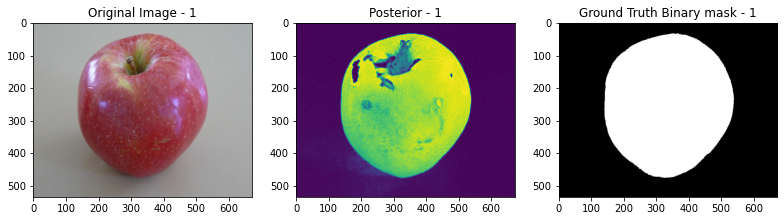

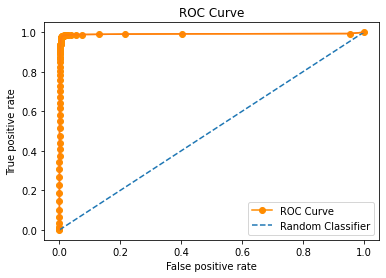

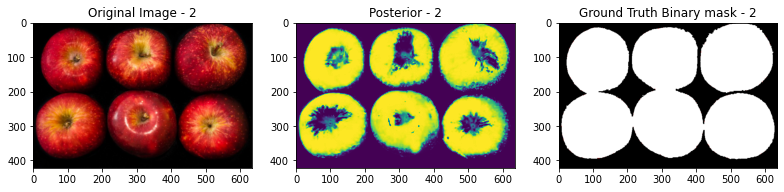

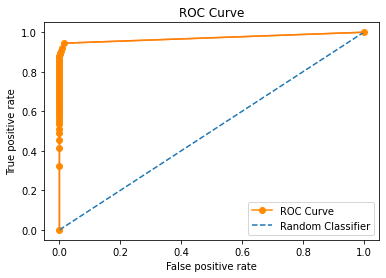

In [ ]:
test_files = glob.glob("apples/test_2/*.jpeg") # import all the custom RGB test images
test_gt_files = glob.glob("masks/test_2/*.jpg") # import all the custom binary mask test images for the above RGB

for i in range(len(test_files)):
    test_im = plt.imread(test_files[i]) # get the pixel values for one RGB image
    test_im = test_im/255
    test_gt = plt.imread(test_gt_files[i]) # get the pixel values for the corresponding ground truth
    test_gt = test_gt/255
    threshold(test_gt) # threshold the float point pixels into class 0 or class 1 based on threshold = 0.5

    n = 100 # run for over 100 threshold values
    # lists to store the false positive rate, true positive rate
    fpr_rate = []
    tpr_rate = []
    f1_score_rate = []
    # calculating the posterior of the test image, given the model parameters
    posterior = calculate_posterior(test_im, mixGaussEst_appleSkin, mixGaussEst_nonappleSkin)
    # using the "red channel" from the ground truth binary mask
    true_value = (test_gt[:, :, 0]).astype(int)
    for t in range(n+1):
        # for every threshold value, calculate the false positive rate, true positive rate
        fpr, tpr, f1_score = calculate_roc(true_value, posterior, t/n)
        fpr_rate.append(fpr)
        tpr_rate.append(tpr)
        f1_score_rate.append(f1_score)
        print('Iteration :: ', t, end='\r')
    
    # plotting the three images (RGB, posterior, ground truth) side by side
    plot_three(test_im,test_gt,posterior, i)
    # plotting the ROC curve
    fig = plt.figure()
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.gca().set_title('ROC Curve')
    x = np.arange(0,1.1,0.1)
    plt.plot(fpr_rate, tpr_rate, marker = 'o', color = 'darkorange', label = 'ROC Curve')
    plt.plot(x, x, linestyle = '--', label =  'Random Classifier')
    plt.legend()
    plt.plot(fpr_rate, tpr_rate)
    # find the area under the curve using the trapezoidal rule
    print('Area under the curve for image ',i+1,': ', abs(auc_curve(tpr_rate, fpr_rate)))
    print('Max F1 score: ', max(f1_score_rate), 'is at threshold: ', np.argmax(f1_score_rate)/100)
    